T. Tarantola, D. Kumaran, P. Dayan, & B. De Martino. (in press) Prior preferences beneficially influence social and non-social learning. Nature Communications.

#Performance simulations

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.misc
import pystan
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import pylab as pl
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def softmax(beta, a, b=0): # Beta = exploration parameter; a = value of modeled choice
    e = np.exp(beta*a)
    e_alt = np.exp(beta*b)
    prob = e / (e + e_alt)
    return prob

def prob(prior,n,x,p=0.8):  
    """
    Bayes's rule for the binomial distribution
    prior is the initial prior
    n is the number of feedback boxes seen so far for this item pair (current trial minus 1)
    x is the number of correct feedback boxes seen so far for this item pair
    """
    q = 1-p
    n_fac = scipy.misc.factorial(n) # n!
    x_fac = scipy.misc.factorial(x) # x!
    n_minus_x_fac = scipy.misc.factorial((n-x)) # (n-x)!
    P_data_correct = ((n_fac)/(x_fac * n_minus_x_fac))*(p**x)*(q**(n-x)) # Probability of x successes if correct answer is assumed to be correct
    P_data_wrong = ((n_fac)/(x_fac * n_minus_x_fac))*(q**x)*(p**(n-x)) # Probability of x successes if wrong answer is assumed to be correct; just switched p and q
    P_correct_data = (P_data_correct * prior)/( (P_data_correct * prior) + (P_data_wrong * (1-prior)) )
    return P_correct_data

def correct_prob(p_corr, a, z, drift_weight):
    prob = np.empty(shape=p_corr.shape)
    v = drift_weight*((2*p_corr) - 1)
    
    prob[np.where(v==0)] = z[np.where(v==0)]
    prob[np.where(v!=0)] = 1 - ( (1 - np.exp(-2*v[np.where(v!=0)]*a*(1-z[np.where(v!=0)])) ) / (np.exp(2*v[np.where(v!=0)]*a*z[np.where(v!=0)]) - np.exp(-2*v[np.where(v!=0)]*a*(1-z[np.where(v!=0)])) ) )
    return prob

#Preference match matrix

##Actual preference data

In [3]:
data = pd.read_pickle('../data/social/data_processed_social_wexclusions.pkl')
control_data = pd.read_pickle('../data/non_social/data_processed_non_social_wexclusions.pkl')
# Concatenate social and control data sets
tojoin = [data,control_data]
data_combined = pd.concat(tojoin)

In [4]:
# Create a dataframe to hold a tally of preferred items
# A separate tally set is recorded for each participant, so that the participant's own preference is not recorded in the tally corresponding to them
data_items = data[data['practice_loop_thisRepN'].isnull()].copy()
items = data_items.bdm_img.unique()
items = items[1:] # Get rid of the single 'nan' in the list
items = items[:20]
prefs = pd.DataFrame(items, columns=['item'])
for i in items:
    prefs.loc[(prefs.item==i),'other_item'] = data_items.loc[(data_items.choice_left==i)].choice_right.values[0]

In [7]:
def extract_dv_first(participant):
    dv = np.empty((20))
    for i in range(0,len(prefs.item)):
        item = prefs.item[i]
        other_item = prefs.other_item[i]
        dv[i] = data_combined.loc[((data_combined.participant==participant)&(data_combined.bdm_img==item)),'bdm_bid1_response'].values[0] - data_combined.loc[((data_combined.participant==participant)&(data_combined.bdm_img==other_item)),'bdm_bid1_response'].values[0] 
    return dv

In [8]:
dv_first_list = np.empty((61,20))
for p in range(0,len(data_combined.participant.unique())):
    dv_first_list[p,:] = extract_dv_first(data_combined.participant.unique()[p])

In [9]:
def extract_dv_correct(participant, target):
    p_dv = dv_first_list[participant,:]
    target_dv = dv_first_list[target,:]
    dv_correct = np.empty(20)
    for i in range(20):
        if target_dv[i]==0: # If the target showed no preference, choose one at random
            dv_correct[i] = (np.random.choice([-1,1]))*p_dv[i]
        elif target_dv[i] <0:
            dv_correct[i] = -p_dv[i]
        elif target_dv[i] >0:
            dv_correct[i] = p_dv[i]
    
    return dv_correct

In [8]:
dv_correct_all_matches = np.empty((61*60,20))
for p in range(61):
    it = 0
    for i in [x for x in xrange(61) if x !=p]:
        dv_correct_all_matches[(p*60 + it), :] = extract_dv_correct(p, i)
        it += 1

#Simulation code

In [9]:
def simulate(itr, dv_correct, drift_weight, learning_prior_temp, choice_bias_temp, threshold):
    """
    Simulate learning another person's preferences with the mean of the group means of the estimated parameters from
    the specified model

    This function simulates a single participant learning the choices made by a single target
    (20 items with 30 trials each), repeated a certain number of times ('itr') to allow for stochasticity in the
    feedback that is presented

    itr = the number of times each item is learned in the simulation
    dv_correct = the preference congruence, based on bids, for the choices being learned
    drift_weight = the mean of the group mean drift weight parameter from the chosen model
    learning_prior_temp = the mean of the group mean inverse temperature parameter used to convert DV into the 
        prior for the Bayesian inference
    choice_bias_temp = the mean of the group mean inverse temperature parameter used to convert DV into the
        bias term in the drift process
    threshold = the mean of the group mean drift threshold
    """

    # Generate array of learning priors (item x iteration)
    if learning_prior_temp==None:
        learning_priors = np.empty(20)
        learning_priors.fill(0.5)
    else:
        learning_priors = softmax(learning_prior_temp, dv_correct)
    learning_priors = np.expand_dims(learning_priors, axis=1)
    learning_priors = np.repeat(learning_priors, itr, axis=1)
    learning_priors_expanded = np.expand_dims(learning_priors, axis=1)
    learning_priors_expanded = np.repeat(learning_priors_expanded, 29, axis=1)

    # Generate array of choice biases (item x iteration)
    if choice_bias_temp==None:
        choice_biases = np.empty(20)
        choice_biases.fill(0.5)
    else:
        choice_biases = softmax(choice_bias_temp, dv_correct)
    choice_biases = np.expand_dims(choice_biases, axis=1)
    choice_biases = np.repeat(choice_biases, itr, axis=1)
    choice_biases_expanded = np.expand_dims(choice_biases, axis=1)
    choice_biases_expanded = np.repeat(choice_biases_expanded, 30, axis=1)

    # Generate feedback (item x feedback-pertinent trial x iteration)
    feedback = np.random.choice([0,1], size=(20,29,itr), p=[0.2,0.8]) 
    feedback_cumulative = np.cumsum(feedback, axis=1)

    # Generate list of trial numbers to use for the binomial calculation (item x trial x iteration)
    trial_numbers = np.expand_dims(np.arange(0,30), axis=1)
    trial_numbers = np.repeat(trial_numbers, itr, axis=1)
    trial_numbers_expanded = np.expand_dims(trial_numbers, axis=0)
    trial_numbers_expanded = np.repeat(trial_numbers_expanded, 20, axis=0)

    # Calculate Bayesian probabilities of correct item being correct
    bayes_probs = np.empty((20,30,itr))
    bayes_probs[:,0,:] = learning_priors
    bayes_probs[:,1:,:] = prob(learning_priors_expanded, trial_numbers_expanded[:,1:,:], feedback_cumulative)

    # Calculate probabilities of correct responses
    response_correct = np.empty((20,30,itr))
    response_correct = correct_prob(bayes_probs, threshold, choice_biases_expanded, drift_weight)

    response_correct_means = np.mean(response_correct, axis=(0,2))
    
    return response_correct_means

#Simulate estimated models

##Load Stan models, grab mean of group mean parameter estimates

In [10]:
# Dual influence model
model_dual_bayesian_noeye_non_social = pickle.load(open('stan/revisions/non_social/pickles/model_dual_bayesian_noeye_non_social.pkl', 'rb'))
fit_dual_bayesian_noeye_non_social = pickle.load(open('stan/revisions/non_social/pickles/fit_dual_bayesian_noeye_non_social.pkl', 'rb'))

In [12]:
dual_drift_weight = fit_dual_bayesian_noeye_non_social['drift_rate_learning_mean'].mean()
dual_learning_prior_temp = fit_dual_bayesian_noeye_non_social['cong_weight_prior_mean'].mean()
dual_choice_bias_temp = fit_dual_bayesian_noeye_non_social['cong_weight_drift_bias_mean'].mean()
dual_threshold = fit_dual_bayesian_noeye_non_social['threshold_int_mean'].mean()

In [6]:
dual_drift_weight = 1.52715710534
dual_learning_prior_temp = 0.979034325587
dual_choice_bias_temp = 0.207009691578
dual_threshold = 2.09770487973

In [13]:
print 'dual_drift_weight: ', dual_drift_weight
print 'dual_learning_prior_temp: ', dual_learning_prior_temp
print 'dual_choice_bias_temp: ', dual_choice_bias_temp
print 'dual_threshold: ', dual_threshold

dual_drift_weight:  1.52715710534
dual_learning_prior_temp:  0.979034325587
dual_choice_bias_temp:  0.207009691578
dual_threshold:  2.09770487973


In [14]:
fit_dual_bayesian_noeye_non_social['cong_weight_prior_mean'].std()

0.26303573270980884

In [15]:
fit_dual_bayesian_noeye_non_social['cong_weight_drift_bias_mean'].std()

0.04061843461257917

Note that the simulations below use the parameter estimates from the dual model, replacing them with neutral alternatives where necessary, for a fairer comparison. This is because we want to compare not the fits of the alternative models, but what performance would look like if the parameters of the best-fitting model were replaced with unbiased alternatives.

##Run simulations

In [5]:
# Load pickles if already saved
null_simulation = np.load('simulation_pickles/null_simulation.npy')
null_simulation_mean = np.mean(null_simulation, axis=0)

choice_simulation = np.load('simulation_pickles/choice_simulation.npy')
choice_simulation_mean = np.mean(choice_simulation, axis=0)

prior_simulation = np.load('simulation_pickles/prior_simulation.npy')
prior_simulation_mean = np.mean(prior_simulation, axis=0)

dual_simulation = np.load('simulation_pickles/dual_simulation.npy')
dual_simulation_mean = np.mean(dual_simulation, axis=0)

In [16]:
# Neutral
null_simulation = np.empty((3660,30))
for i in range(3660):
    null_simulation[i,:] = simulate(1000, dv_correct_all_matches[i], dual_drift_weight, None,
                                    None, dual_threshold)
null_simulation_mean = np.mean(null_simulation, axis=0)
np.save('simulation_pickles/null_simulation.npy', null_simulation)
print 'Done neutral'

# Influenced choice
choice_simulation = np.empty((3660,30))
for i in range(3660):
    choice_simulation[i,:] = simulate(1000, dv_correct_all_matches[i], dual_drift_weight, None,
                                    dual_choice_bias_temp, dual_threshold)
choice_simulation_mean = np.mean(choice_simulation, axis=0)
np.save('simulation_pickles/choice_simulation.npy', choice_simulation)
print 'Done choice'

# Influenced prior
prior_simulation = np.empty((3660,30))
for i in range(3660):
    prior_simulation[i,:] = simulate(1000, dv_correct_all_matches[i], dual_drift_weight, dual_learning_prior_temp,
                                    None, dual_threshold)
prior_simulation_mean = np.mean(prior_simulation, axis=0)
np.save('simulation_pickles/prior_simulation.npy', prior_simulation)
print 'Done prior'

# Dual influence
dual_simulation = np.empty((3660,30))
for i in range(3660):
    dual_simulation[i,:] = simulate(1000, dv_correct_all_matches[i], dual_drift_weight, dual_learning_prior_temp,
                                    dual_choice_bias_temp, dual_threshold)
dual_simulation_mean = np.mean(dual_simulation, axis=0)
np.save('simulation_pickles/dual_simulation.npy', dual_simulation)
print 'Done dual'

Done neutral
Done choice
Done prior
Done dual


In [9]:
print np.sum(null_simulation_mean)*20, ((np.sum(null_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))
print np.sum(choice_simulation_mean)*20, ((np.sum(choice_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))
print np.sum(prior_simulation_mean)*20, ((np.sum(prior_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))
print np.sum(dual_simulation_mean)*20, ((np.sum(dual_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))
print ''
print ((np.sum(choice_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))*600
print ((np.sum(prior_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))*600
print ((np.sum(dual_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))*600

548.068255936 0.0
549.8763325 0.00329899888163
550.81047354 0.00500342352139
552.21596246 0.00756786491141

1.97939932898
3.00205411283
4.54071894684


In [18]:
dual_threshold

2.0977048797286719

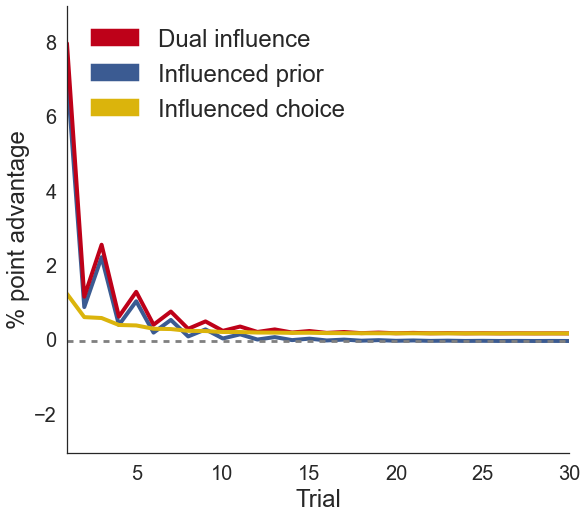

In [13]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (9.0, 8.0)
ax = plt.subplot()
plt.plot(range(1,31),(prior_simulation_mean - null_simulation_mean)*100, color=sns.xkcd_rgb['denim blue'], linewidth=4)
plt.plot(range(1,31),(dual_simulation_mean - null_simulation_mean)*100, color=sns.xkcd_rgb['scarlet'], linewidth=4)
plt.plot(range(1,31),(choice_simulation_mean - null_simulation_mean)*100, color=sns.xkcd_rgb['gold'], linewidth=4)
plt.xlim((1,30))
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.ylim((-3,9))
plt.ylabel('% point advantage', size=24)
plt.xlabel('Trial', size=24)

prior_patch = mpatches.Patch(color=sns.xkcd_rgb['denim blue'], label='Influenced prior')
choice_patch = mpatches.Patch(color=sns.xkcd_rgb['gold'], label='Influenced choice')
dual_patch = mpatches.Patch(color=sns.xkcd_rgb['scarlet'], label='Dual influence')
plt.tick_params(axis='both', which='both', labelsize=20)
plt.legend(handles=[dual_patch, prior_patch, choice_patch], bbox_to_anchor=(0.3,1), loc=9, fontsize=24)
#plt.title('Actual Preference Data',size=34, position=[0.5,1.05])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../figures/fig7a_right-simulation_performance_advantages.svg')

In [15]:
# Influenced prior advantage on the first trial
prior_simulation_mean[0] - null_simulation_mean[0]

0.072130635943934651

In [16]:
# Influenced choice advantage on the first trial
choice_simulation_mean[0] - null_simulation_mean[0]

0.012684452829893611

In [17]:
choice_advantage_last10 = (choice_simulation_mean - null_simulation_mean)[20:].mean()
choice_advantage_last10

0.0020488408321047815

In [18]:
dual_advantage_last10 = (dual_simulation_mean - null_simulation_mean)[20:].mean()
dual_advantage_last10

0.0020785449445846816

In [19]:
prior_advantage_last10 = (prior_simulation_mean - null_simulation_mean)[20:].mean()
prior_advantage_last10

4.0225021058770682e-05

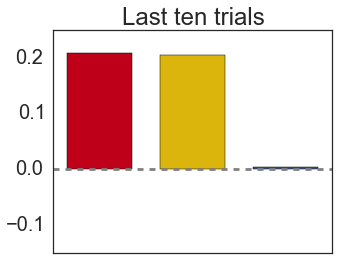

In [20]:
ax = plt.figure(figsize=(5,4))
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',  # ticks along the top edge are off
    labelbottom='off')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.bar(range(3),[dual_advantage_last10*100, choice_advantage_last10*100, prior_advantage_last10*100], width=0.7, align='center', color=[sns.xkcd_rgb['scarlet'],sns.xkcd_rgb['gold'],sns.xkcd_rgb['denim blue']])
plt.ylim((-0.15,0.25))
plt.yticks([-0.1,0,0.1,0.2])
plt.axhline(y=0, color='grey', linestyle='dashed')
plt.title('Last ten trials', size=24)
plt.savefig('../figures/fig7a_right_inset-simulation_performance_advantages_last10.svg', bbox_inches='tight')

#Simulate models for zero correlation DV randomly generated data

##Randomly generated preference data with no correlation

In [27]:
dv_first_list_random_sd = dv_first_list.std(axis=1).mean()

In [29]:
dv_first_list_random = np.empty((61,20))
for p in range(61):
    dv_first_list_random[p,:] = np.random.normal(loc=0, scale=dv_first_list_random_sd, size=20)

In [30]:
def extract_dv_correct_random(participant, target):
    p_dv = dv_first_list_random[participant,:]
    target_dv = dv_first_list_random[target,:]
    dv_correct = np.empty(20)
    for i in range(20):
        if target_dv[i]==0: # If the target showed no preference, choose one at random
            dv_correct[i] = (np.random.choice([-1,1]))*p_dv[i]
        elif target_dv[i] <0:
            dv_correct[i] = -p_dv[i]
        elif target_dv[i] >0:
            dv_correct[i] = p_dv[i]
    
    return dv_correct

In [31]:
dv_correct_all_matches_random = np.empty((61*60,20))
for p in range(61):
    it = 0
    for i in [x for x in xrange(61) if x !=p]:
        dv_correct_all_matches_random[(p*60 + it), :] = extract_dv_correct_random(p, i)
        it += 1

In [32]:
# Check that the mean DV from the random data is 0
dv_correct_all_matches_random.std()

0.72998516551937631

##Run simulations

In [6]:
# Load pickles if already saved
null_simulation_random = np.load('simulation_pickles/null_simulation_random.npy')
null_simulation_random_mean = np.mean(null_simulation_random, axis=0)

choice_simulation_random = np.load('simulation_pickles/choice_simulation_random.npy')
choice_simulation_random_mean = np.mean(choice_simulation_random, axis=0)

prior_simulation_random = np.load('simulation_pickles/prior_simulation_random.npy')
prior_simulation_random_mean = np.mean(prior_simulation_random, axis=0)

dual_simulation_random = np.load('simulation_pickles/dual_simulation_random.npy')
dual_simulation_random_mean = np.mean(dual_simulation_random, axis=0)

In [33]:
# Neutral actor
null_simulation_random = np.empty((3660,30))
for i in range(3660):
    null_simulation_random[i,:] = simulate(1000, dv_correct_all_matches_random[i], dual_drift_weight, None,
                                    None, dual_threshold)
null_simulation_random_mean = np.mean(null_simulation_random, axis=0)
np.save('simulation_pickles/null_simulation_random.npy', null_simulation_random)
print 'Done neutral'

# Influenced choice
choice_simulation_random = np.empty((3660,30))
for i in range(3660):
    choice_simulation_random[i,:] = simulate(1000, dv_correct_all_matches_random[i], dual_drift_weight, None,
                                    dual_choice_bias_temp, dual_threshold)
choice_simulation_random_mean = np.mean(choice_simulation_random, axis=0)
np.save('simulation_pickles/choice_simulation_random.npy', choice_simulation_random)
print 'Done choice'

# Influenced prior
prior_simulation_random = np.empty((3660,30))
for i in range(3660):
    prior_simulation_random[i,:] = simulate(1000, dv_correct_all_matches_random[i], dual_drift_weight, dual_learning_prior_temp,
                                    None, dual_threshold)
prior_simulation_random_mean = np.mean(prior_simulation_random, axis=0)
np.save('simulation_pickles/prior_simulation_random.npy', prior_simulation_random)
print 'Done prior'

# Dual influence
dual_simulation_random = np.empty((3660,30))
for i in range(3660):
    dual_simulation_random[i,:] = simulate(1000, dv_correct_all_matches_random[i], dual_drift_weight, dual_learning_prior_temp,
                                    dual_choice_bias_temp, dual_threshold)
dual_simulation_random_mean = np.mean(dual_simulation_random, axis=0)
np.save('simulation_pickles/dual_simulation_random.npy', dual_simulation_random)
print 'Done dual'

Done neutral
Done choice
Done prior
Done dual


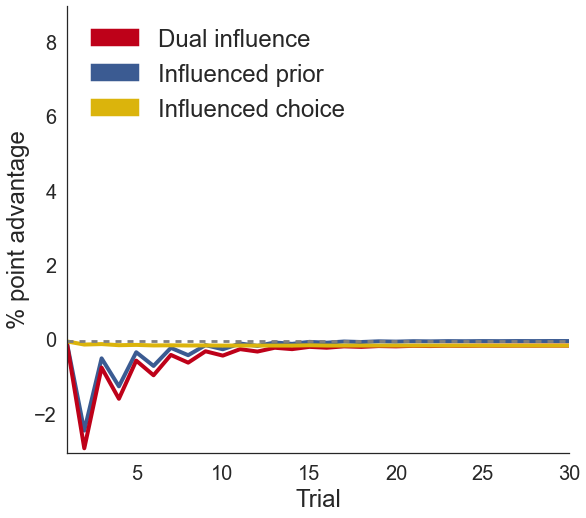

In [22]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (9.0, 8.0)
ax = plt.subplot()
plt.plot(range(1,31),(prior_simulation_random_mean - null_simulation_random_mean)*100, color=sns.xkcd_rgb['denim blue'], linewidth=4)
plt.plot(range(1,31),(dual_simulation_random_mean - null_simulation_random_mean)*100, color=sns.xkcd_rgb['scarlet'], linewidth=4)
plt.plot(range(1,31),(choice_simulation_random_mean - null_simulation_random_mean)*100, color=sns.xkcd_rgb['gold'], linewidth=4)
plt.xlim((1,30))
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.ylim((-3,9))
plt.ylabel('% point advantage', size=24)
plt.xlabel('Trial', size=24)

prior_patch = mpatches.Patch(color=sns.xkcd_rgb['denim blue'], label='Influenced prior')
choice_patch = mpatches.Patch(color=sns.xkcd_rgb['gold'], label='Influenced choice')
dual_patch = mpatches.Patch(color=sns.xkcd_rgb['scarlet'], label='Dual influence')
plt.tick_params(axis='both', which='both', labelsize=20)
plt.legend(handles=[dual_patch, prior_patch, choice_patch], bbox_to_anchor=(0.3,1), loc=9, fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title('Random Preference Data',size=34, position=[0.5,1.05])
plt.savefig('../figures/fig7b_right-simulation_performance_advantages_random.svg')

In [7]:
choice_advantage_random_last10 = (choice_simulation_random_mean - null_simulation_random_mean)[20:].mean()
choice_advantage_random_last10

-0.0012281714286938362

In [8]:
dual_advantage_random_last10 = (dual_simulation_random_mean - null_simulation_random_mean)[20:].mean()
dual_advantage_random_last10

-0.00127673600475684

In [9]:
prior_advantage_random_last10 = (prior_simulation_random_mean - null_simulation_random_mean)[20:].mean()
prior_advantage_random_last10

-3.6118443686927736e-05

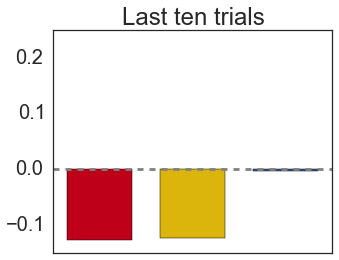

In [26]:
plt.figure(figsize=(5,4))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.yticks([-0.1,0,0.1,0.2])
plt.bar(range(3),[dual_advantage_random_last10*100, choice_advantage_random_last10*100, prior_advantage_random_last10*100], width=0.7, align='center', color=[sns.xkcd_rgb['scarlet'],sns.xkcd_rgb['gold'],sns.xkcd_rgb['denim blue']])
plt.ylim((-0.15,0.25))
plt.axhline(y=0, color='grey', linestyle='dashed')
plt.title('Last ten trials', size=24)
plt.savefig('../figures/fig7b_right_inset-simulation_performance_advantages_random_last10.svg', bbox_inches='tight')

In [45]:
# How much bigger is the overall performance benefit in the real data compared to the disadvantage in the random data?
5951.0/1682.0

3.538049940546968

In [10]:
# In percentage point terms
dual_random_disadvantage = ((np.sum(dual_simulation_random_mean) - np.sum(null_simulation_random_mean))*20) / 600
dual_advantage = ((np.sum(dual_simulation_mean) - np.sum(null_simulation_mean))*20) / 600
print dual_advantage / dual_random_disadvantage

-1.8205361444


# Simulate in task with noisier feedback (0.7)

In [50]:
def simulate_noise(itr, feedback, dv_correct, drift_weight, learning_prior_temp, choice_bias_temp, threshold):
    """
    Simulate learning another person's preferences with the mean of the group means of the estimated parameters from
    the specified model

    This function simulates a single participant learning the choices made by a single target
    (20 items with 30 trials each), repeated a certain number of times ('itr') to allow for stochasticity in the
    feedback that is presented

    itr = the number of times each item is learned in the simulation
    feedback = probability of feedback showing the correct answer on any given trial
    dv_correct = the preference congruence, based on bids, for the choices being learned
    drift_weight = the mean of the group mean drift weight parameter from the chosen model
    learning_prior_temp = the mean of the group mean inverse temperature parameter used to convert DV into the 
        prior for the Bayesian inference
    choice_bias_temp = the mean of the group mean inverse temperature parameter used to convert DV into the
        bias term in the drift process
    threshold = the mean of the group mean drift threshold
    """

    # Generate array of learning priors (item x iteration)
    if learning_prior_temp==None:
        learning_priors = np.empty(20)
        learning_priors.fill(0.5)
    else:
        learning_priors = softmax(learning_prior_temp, dv_correct)
    learning_priors = np.expand_dims(learning_priors, axis=1)
    learning_priors = np.repeat(learning_priors, itr, axis=1)
    learning_priors_expanded = np.expand_dims(learning_priors, axis=1)
    learning_priors_expanded = np.repeat(learning_priors_expanded, 29, axis=1)

    # Generate array of choice biases (item x iteration)
    if choice_bias_temp==None:
        choice_biases = np.empty(20)
        choice_biases.fill(0.5)
    else:
        choice_biases = softmax(choice_bias_temp, dv_correct)
    choice_biases = np.expand_dims(choice_biases, axis=1)
    choice_biases = np.repeat(choice_biases, itr, axis=1)
    choice_biases_expanded = np.expand_dims(choice_biases, axis=1)
    choice_biases_expanded = np.repeat(choice_biases_expanded, 30, axis=1)

    # Generate feedback (item x feedback-pertinent trial x iteration)
    feedback = np.random.choice([0,1], size=(20,29,itr), p=[1-feedback,feedback]) 
    feedback_cumulative = np.cumsum(feedback, axis=1)

    # Generate list of trial numbers to use for the binomial calculation (item x trial x iteration)
    trial_numbers = np.expand_dims(np.arange(0,30), axis=1)
    trial_numbers = np.repeat(trial_numbers, itr, axis=1)
    trial_numbers_expanded = np.expand_dims(trial_numbers, axis=0)
    trial_numbers_expanded = np.repeat(trial_numbers_expanded, 20, axis=0)

    # Calculate Bayesian probabilities of correct item being correct
    bayes_probs = np.empty((20,30,itr))
    bayes_probs[:,0,:] = learning_priors
    bayes_probs[:,1:,:] = prob(learning_priors_expanded, trial_numbers_expanded[:,1:,:], feedback_cumulative)

    # Calculate probabilities of correct responses
    response_correct = np.empty((20,30,itr))
    response_correct = correct_prob(bayes_probs, threshold, choice_biases_expanded, drift_weight)

    response_correct_means = np.mean(response_correct, axis=(0,2))
    
    return response_correct_means

In [51]:
# Neutral actor
null_simulation_seven = np.empty((3660,30))
for i in range(3660):
    null_simulation_seven[i,:] = simulate_noise(1000, 0.7, dv_correct_all_matches[i], dual_drift_weight, None,
                                    None, dual_threshold)
null_simulation_seven_mean = np.mean(null_simulation_seven, axis=0)
np.save('simulation_pickles/null_simulation_seven.npy', null_simulation_seven)
print 'Done neutral'

# Influenced choice
choice_simulation_seven = np.empty((3660,30))
for i in range(3660):
    choice_simulation_seven[i,:] = simulate_noise(1000, 0.7, dv_correct_all_matches[i], dual_drift_weight, None,
                                    dual_choice_bias_temp, dual_threshold)
choice_simulation_seven_mean = np.mean(choice_simulation_seven, axis=0)
np.save('simulation_pickles/choice_simulation_seven.npy', choice_simulation_seven)
print 'Done choice'

# Influenced prior
prior_simulation_seven = np.empty((3660,30))
for i in range(3660):
    prior_simulation_seven[i,:] = simulate_noise(1000, 0.7, dv_correct_all_matches[i], dual_drift_weight, dual_learning_prior_temp,
                                    None, dual_threshold)
prior_simulation_seven_mean = np.mean(prior_simulation_seven, axis=0)
np.save('simulation_pickles/prior_simulation_seven.npy', prior_simulation_seven)
print 'Done prior'

# Dual influence
dual_simulation_seven = np.empty((3660,30))
for i in range(3660):
    dual_simulation_seven[i,:] = simulate_noise(1000, 0.7, dv_correct_all_matches[i], dual_drift_weight, dual_learning_prior_temp,
                                    dual_choice_bias_temp, dual_threshold)
dual_simulation_seven_mean = np.mean(dual_simulation_seven, axis=0)
np.save('simulation_pickles/dual_simulation_seven.npy', dual_simulation_seven)
print 'Done dual'

Done neutral
Done choice
Done prior
Done dual


In [11]:
# Load pickles if already saved
null_simulation_seven = np.load('simulation_pickles/null_simulation_seven.npy')
null_simulation_seven_mean = np.mean(null_simulation_seven, axis=0)

choice_simulation_seven = np.load('simulation_pickles/choice_simulation_seven.npy')
choice_simulation_seven_mean = np.mean(choice_simulation_seven, axis=0)

prior_simulation_seven = np.load('simulation_pickles/prior_simulation_seven.npy')
prior_simulation_seven_mean = np.mean(prior_simulation_seven, axis=0)

dual_simulation_seven = np.load('simulation_pickles/dual_simulation_seven.npy')
dual_simulation_seven_mean = np.mean(dual_simulation_seven, axis=0)

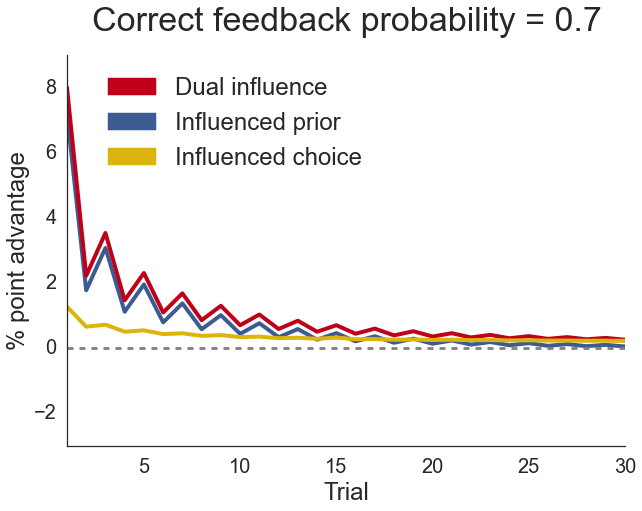

In [29]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (10.0, 7.0)
ax = plt.subplot()
plt.plot(range(1,31),(prior_simulation_seven_mean - null_simulation_seven_mean)*100, color=sns.xkcd_rgb['denim blue'], linewidth=4)
plt.plot(range(1,31),(dual_simulation_seven_mean - null_simulation_seven_mean)*100, color=sns.xkcd_rgb['scarlet'], linewidth=4)
plt.plot(range(1,31),(choice_simulation_seven_mean - null_simulation_seven_mean)*100, color=sns.xkcd_rgb['gold'], linewidth=4)
plt.xlim((1,30))
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.ylim((-3,9))
plt.ylabel('% point advantage', size=24)
plt.xlabel('Trial', size=24)

prior_patch = mpatches.Patch(color=sns.xkcd_rgb['denim blue'], label='Influenced prior')
choice_patch = mpatches.Patch(color=sns.xkcd_rgb['gold'], label='Influenced choice')
dual_patch = mpatches.Patch(color=sns.xkcd_rgb['scarlet'], label='Dual influence')
plt.tick_params(axis='both', which='both', labelsize=20)
plt.legend(handles=[dual_patch, prior_patch, choice_patch], bbox_to_anchor=(0.3,1), loc=9, fontsize=24)
plt.title('Correct feedback probability = 0.7',size=34, position=[0.5,1.05])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('../figures/supp-fig7b-simulation_performance_advantages_seven.svg')

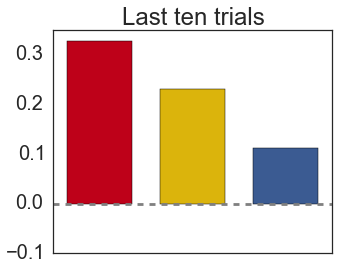

In [30]:
choice_advantage_seven_last10 = (choice_simulation_seven_mean - null_simulation_seven_mean)[20:].mean()
dual_advantage_seven_last10 = (dual_simulation_seven_mean - null_simulation_seven_mean)[20:].mean()
prior_advantage_seven_last10 = (prior_simulation_seven_mean - null_simulation_seven_mean)[20:].mean()

plt.figure(figsize=(5,4))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.bar(range(3),[dual_advantage_seven_last10*100, choice_advantage_seven_last10*100, prior_advantage_seven_last10*100], width=0.7, align='center', color=[sns.xkcd_rgb['scarlet'],sns.xkcd_rgb['gold'],sns.xkcd_rgb['denim blue']])
plt.ylim((-0.1,0.35))
plt.yticks([-0.1,0,0.1,0.2,0.3])

plt.axhline(y=0, color='grey', linestyle='dashed')
plt.title('Last ten trials', size=24)
plt.savefig('../figures/supp-fig7b_inset-simulation_performance_advantages_seven_last10.svg', bbox_inches='tight')

# Simulate in task with noisier feedback (0.6)

In [59]:
# Neutral actor
null_simulation_six = np.empty((3660,30))
for i in range(3660):
    null_simulation_six[i,:] = simulate_noise(1000, 0.6, dv_correct_all_matches[i], dual_drift_weight, None,
                                    None, dual_threshold)
null_simulation_six_mean = np.mean(null_simulation_six, axis=0)
np.save('simulation_pickles/null_simulation_six.npy', null_simulation_six)
print 'Done neutral'

# Influenced choice
choice_simulation_six = np.empty((3660,30))
for i in range(3660):
    choice_simulation_six[i,:] = simulate_noise(1000, 0.6, dv_correct_all_matches[i], dual_drift_weight, None,
                                    dual_choice_bias_temp, dual_threshold)
choice_simulation_six_mean = np.mean(choice_simulation_six, axis=0)
np.save('simulation_pickles/choice_simulation_six.npy', choice_simulation_six)
print 'Done choice'

# Influenced prior
prior_simulation_six = np.empty((3660,30))
for i in range(3660):
    prior_simulation_six[i,:] = simulate_noise(1000, 0.6, dv_correct_all_matches[i], dual_drift_weight, dual_learning_prior_temp,
                                    None, dual_threshold)
prior_simulation_six_mean = np.mean(prior_simulation_six, axis=0)
np.save('simulation_pickles/prior_simulation_six.npy', prior_simulation_six)
print 'Done prior'

# Dual influence
dual_simulation_six = np.empty((3660,30))
for i in range(3660):
    dual_simulation_six[i,:] = simulate_noise(1000, 0.6, dv_correct_all_matches[i], dual_drift_weight, dual_learning_prior_temp,
                                    dual_choice_bias_temp, dual_threshold)
dual_simulation_six_mean = np.mean(dual_simulation_six, axis=0)
np.save('simulation_pickles/dual_simulation_six.npy', dual_simulation_six)
print 'Done dual'

Done neutral
Done choice
Done prior
Done dual


In [12]:
# Load pickles if already saved
null_simulation_six = np.load('simulation_pickles/null_simulation_six.npy')
null_simulation_six_mean = np.mean(null_simulation_six, axis=0)

choice_simulation_six = np.load('simulation_pickles/choice_simulation_six.npy')
choice_simulation_six_mean = np.mean(choice_simulation_six, axis=0)

prior_simulation_six = np.load('simulation_pickles/prior_simulation_six.npy')
prior_simulation_six_mean = np.mean(prior_simulation_six, axis=0)

dual_simulation_six = np.load('simulation_pickles/dual_simulation_six.npy')
dual_simulation_six_mean = np.mean(dual_simulation_six, axis=0)

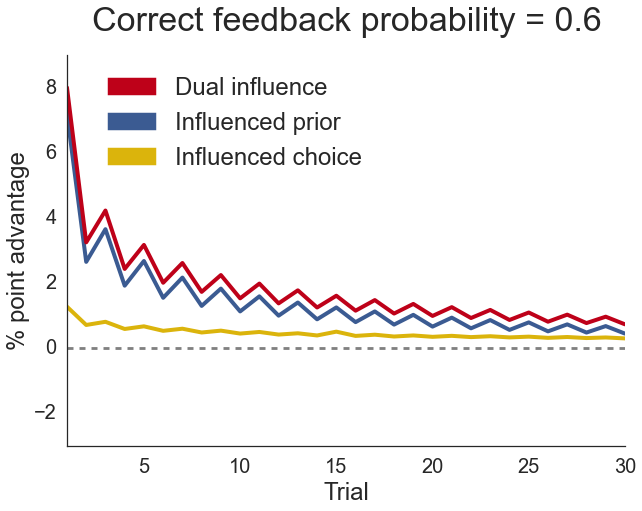

In [32]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (10.0, 7.0)
ax = plt.subplot()
plt.plot(range(1,31),(prior_simulation_six_mean - null_simulation_six_mean)*100, color=sns.xkcd_rgb['denim blue'], linewidth=4)
plt.plot(range(1,31),(dual_simulation_six_mean - null_simulation_six_mean)*100, color=sns.xkcd_rgb['scarlet'], linewidth=4)
plt.plot(range(1,31), (choice_simulation_six_mean - null_simulation_six_mean)*100, color=sns.xkcd_rgb['gold'], linewidth=4)
plt.xlim((1,30))
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.ylim((-3,9))
plt.ylabel('% point advantage', size=24)
plt.xlabel('Trial', size=24)

prior_patch = mpatches.Patch(color=sns.xkcd_rgb['denim blue'], label='Influenced prior')
choice_patch = mpatches.Patch(color=sns.xkcd_rgb['gold'], label='Influenced choice')
dual_patch = mpatches.Patch(color=sns.xkcd_rgb['scarlet'], label='Dual influence')
plt.tick_params(axis='both', which='both', labelsize=20)
plt.legend(handles=[dual_patch, prior_patch, choice_patch], bbox_to_anchor=(0.3,1), loc=9, fontsize=24)
plt.title('Correct feedback probability = 0.6',size=34, position=[0.5,1.05])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('../figures/supp-fig7c-simulation_performance_advantages_six.svg')

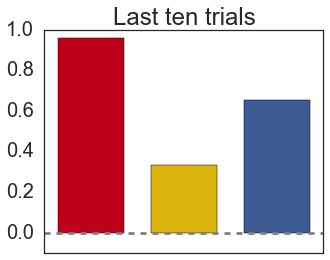

In [33]:
choice_advantage_six_last10 = (choice_simulation_six_mean - null_simulation_six_mean)[20:].mean()
dual_advantage_six_last10 = (dual_simulation_six_mean - null_simulation_six_mean)[20:].mean()
prior_advantage_six_last10 = (prior_simulation_six_mean - null_simulation_six_mean)[20:].mean()

plt.figure(figsize=(5,4))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.bar(range(3),[dual_advantage_six_last10*100, choice_advantage_six_last10*100, prior_advantage_six_last10*100], width=0.7, align='center', color=[sns.xkcd_rgb['scarlet'],sns.xkcd_rgb['gold'],sns.xkcd_rgb['denim blue']])
plt.ylim((-0.1,1.0))
plt.axhline(y=0, color='grey', linestyle='dashed')
plt.title('Last ten trials', size=24)
plt.savefig('../figures/supp-fig7c_inset-simulation_performance_advantages_six_last10.svg', bbox_inches='tight')

#Plot performance boost by feedback noise

In [13]:
dual_08 = ((np.sum(dual_simulation_mean) - np.sum(null_simulation_mean))*20) / 600
dual_07 = ((np.sum(dual_simulation_seven_mean) - np.sum(null_simulation_seven_mean))*20) / 600
dual_06 = ((np.sum(dual_simulation_six_mean) - np.sum(null_simulation_six_mean))*20) / 600

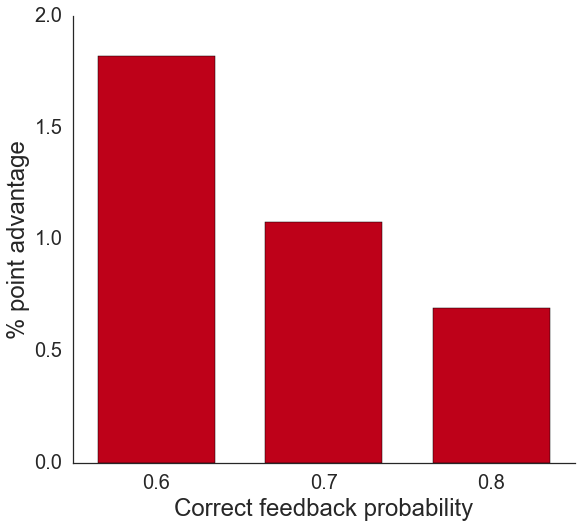

In [37]:
plt.figure(figsize=(9,8))
ax = plt.subplot()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.bar(range(3),[dual_06*100, dual_07*100, dual_08*100], width=0.7, align='center', color=[sns.xkcd_rgb['scarlet'],sns.xkcd_rgb['scarlet'],sns.xkcd_rgb['scarlet']])
#plt.ylim((-0.001,0.008))
#plt.axhline(y=0, color='grey', linestyle='dashed')
plt.xlabel('Correct feedback probability', size=24)
plt.ylabel('% point advantage', size=24)
x_labels = ['','0.6','','0.7','','0.8','']
plt.xticks((-0.5,0,0.5,1,1.5,2,2.5),x_labels, size=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../figures/supp-fig7a_inset-simulation_feedback_noise_comparison.svg', bbox_inches='tight')

#Plot total performance advantage for range of different parameters

##Using actual preference data

In [11]:
def simulate_param_range(choice_factor, prior_factor):
    simulation = np.empty((3660,30))
    for i in range(3660):
        simulation[i,:] = simulate(1000, dv_correct_all_matches[i], dual_drift_weight, dual_learning_prior_temp*prior_factor,
                                        dual_choice_bias_temp*choice_factor, dual_threshold)
    np.save('simulation_pickles/param_ranges/%s.npy' %('choice'+str(choice_factor)+'_prior'+str(prior_factor)), simulation)
    print 'Done %s' %('choice'+str(choice_factor)+'_prior'+str(prior_factor))

In [12]:
simulate_param_range(0,0.25)
simulate_param_range(0,0.5)
simulate_param_range(0,2)
simulate_param_range(0,4)
simulate_param_range(0,8)

Done choice0_prior0.25
Done choice0_prior0.5
Done choice0_prior2
Done choice0_prior4
Done choice0_prior8


In [110]:
# This core
simulate_param_range(0,0.25)
simulate_param_range(0,0.5)
simulate_param_range(0,2)
simulate_param_range(0,4)
simulate_param_range(0,8)

# Core 1
simulate_param_range(0.25,0)
simulate_param_range(0.25,0.25)
simulate_param_range(0.25,0.5)
simulate_param_range(0.25,1)
simulate_param_range(0.25,2)
simulate_param_range(0.25,4)
simulate_param_range(0.25,8)

# Core 2
simulate_param_range(0.5,0)
simulate_param_range(0.5,0.25)
simulate_param_range(0.5,0.5)
simulate_param_range(0.5,1)
simulate_param_range(0.5,2)
simulate_param_range(0.5,4)
simulate_param_range(0.5,8)

# Core 3
simulate_param_range(1,0.25)
simulate_param_range(1,0.5)
simulate_param_range(1,2)
simulate_param_range(1,4)
simulate_param_range(1,8)

# Core 4
simulate_param_range(2,0)
simulate_param_range(2,0.25)
simulate_param_range(2,0.5)
simulate_param_range(2,1)
simulate_param_range(2,2)
simulate_param_range(2,4)
simulate_param_range(2,8)

# Core 5
simulate_param_range(4,0)
simulate_param_range(4,0.25)
simulate_param_range(4,0.5)
simulate_param_range(4,1)
simulate_param_range(4,2)
simulate_param_range(4,4)
simulate_param_range(4,8)

# Core 6
simulate_param_range(8,0)
simulate_param_range(8,0.25)
simulate_param_range(8,0.5)
simulate_param_range(8,1)
simulate_param_range(8,2)
simulate_param_range(8,4)
simulate_param_range(8,8)

Done choice0_prior2
Done choice0_prior10
Done choice0_prior100
Done choice0.1_prior0
Done choice0.1_prior0.1
Done choice0.1_prior0.5
Done choice0.1_prior1
Done choice0.1_prior2
Done choice0.1_prior10
Done choice0.1_prior100
Done choice0.5_prior0
Done choice0.5_prior0.1
Done choice0.5_prior0.5
Done choice0.5_prior1
Done choice0.5_prior2
Done choice0.5_prior10
Done choice0.5_prior100
Done choice1_prior0.1
Done choice1_prior0.5
Done choice1_prior2
Done choice1_prior10
Done choice1_prior100
Done choice2_prior0
Done choice2_prior0.1
Done choice2_prior0.5
Done choice2_prior1
Done choice2_prior2
Done choice2_prior10
Done choice2_prior100
Done choice10_prior0
Done choice10_prior0.1
Done choice10_prior0.5
Done choice10_prior1
Done choice10_prior2
Done choice10_prior10
Done choice10_prior100
Done choice100_prior0
Done choice100_prior0.1
Done choice100_prior0.5
Done choice100_prior1
Done choice100_prior2
Done choice100_prior10
Done choice100_prior100


In [14]:
choice_groups = 7
prior_groups = 7
actual_pref_sim_matrix = np.empty((choice_groups,prior_groups))

choice0_prior0 = np.load('simulation_pickles/null_simulation.npy')
choice0_prior0_mean = np.mean(choice0_prior0, axis=0)
null_simulation_mean = choice0_prior0_mean
# Percentage point performance advantage over neutral model, summed across all trials
actual_pref_sim_matrix[0,0] = 0

choice0_prior025 = np.load('simulation_pickles/param_ranges/choice0_prior0.25.npy')
choice0_prior025_mean = np.mean(choice0_prior025, axis=0)
# Percentage point performance advantage over neutral model, summed across all trials
actual_pref_sim_matrix[0,1] = (((np.sum(choice0_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice0_prior05 = np.load('simulation_pickles/param_ranges/choice0_prior0.5.npy')
choice0_prior05_mean = np.mean(choice0_prior05, axis=0)
actual_pref_sim_matrix[0,2] = (((np.sum(choice0_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100

choice0_prior1 = np.load('simulation_pickles/prior_simulation.npy')
choice0_prior1_mean = np.mean(choice0_prior1, axis=0)
actual_pref_sim_matrix[0,3] = (((np.sum(choice0_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100

choice0_prior2 = np.load('simulation_pickles/param_ranges/choice0_prior2.npy')
choice0_prior2_mean = np.mean(choice0_prior2, axis=0)
actual_pref_sim_matrix[0,4] = (((np.sum(choice0_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice0_prior4 = np.load('simulation_pickles/param_ranges/choice0_prior4.npy')
choice0_prior4_mean = np.mean(choice0_prior4, axis=0)
actual_pref_sim_matrix[0,5] = (((np.sum(choice0_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice0_prior8 = np.load('simulation_pickles/param_ranges/choice0_prior8.npy')
choice0_prior8_mean = np.mean(choice0_prior8, axis=0)
actual_pref_sim_matrix[0,6] = (((np.sum(choice0_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice025_prior0 = np.load('simulation_pickles/param_ranges/choice0.25_prior0.npy')
choice025_prior0_mean = np.mean(choice025_prior0, axis=0)
actual_pref_sim_matrix[1,0] = (((np.sum(choice025_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice025_prior025 = np.load('simulation_pickles/param_ranges/choice0.25_prior0.25.npy')
choice025_prior025_mean = np.mean(choice025_prior025, axis=0)
actual_pref_sim_matrix[1,1] = (((np.sum(choice025_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice025_prior05 = np.load('simulation_pickles/param_ranges/choice0.25_prior0.5.npy')
choice025_prior05_mean = np.mean(choice025_prior05, axis=0)
actual_pref_sim_matrix[1,2] = (((np.sum(choice025_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice025_prior1 = np.load('simulation_pickles/param_ranges/choice0.25_prior1.npy')
choice025_prior1_mean = np.mean(choice025_prior1, axis=0)
actual_pref_sim_matrix[1,3] = (((np.sum(choice025_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice025_prior2 = np.load('simulation_pickles/param_ranges/choice0.25_prior2.npy')
choice025_prior2_mean = np.mean(choice025_prior2, axis=0)
actual_pref_sim_matrix[1,4] = (((np.sum(choice025_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice025_prior4 = np.load('simulation_pickles/param_ranges/choice0.25_prior4.npy')
choice025_prior4_mean = np.mean(choice025_prior4, axis=0)
actual_pref_sim_matrix[1,5] = (((np.sum(choice025_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice025_prior8 = np.load('simulation_pickles/param_ranges/choice0.25_prior8.npy')
choice025_prior8_mean = np.mean(choice025_prior8, axis=0)
actual_pref_sim_matrix[1,6] = (((np.sum(choice025_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice05_prior0 = np.load('simulation_pickles/param_ranges/choice0.5_prior0.npy')
choice05_prior0_mean = np.mean(choice05_prior0, axis=0)
actual_pref_sim_matrix[2,0] = (((np.sum(choice05_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice05_prior025 = np.load('simulation_pickles/param_ranges/choice0.5_prior0.25.npy')
choice05_prior025_mean = np.mean(choice05_prior025, axis=0)
actual_pref_sim_matrix[2,1] = (((np.sum(choice05_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice05_prior05 = np.load('simulation_pickles/param_ranges/choice0.5_prior0.5.npy')
choice05_prior05_mean = np.mean(choice05_prior05, axis=0)
actual_pref_sim_matrix[2,2] = (((np.sum(choice05_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice05_prior1 = np.load('simulation_pickles/param_ranges/choice0.5_prior1.npy')
choice05_prior1_mean = np.mean(choice05_prior1, axis=0)
actual_pref_sim_matrix[2,3] = (((np.sum(choice05_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice05_prior2 = np.load('simulation_pickles/param_ranges/choice0.5_prior2.npy')
choice05_prior2_mean = np.mean(choice05_prior2, axis=0)
actual_pref_sim_matrix[2,4] = (((np.sum(choice05_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice05_prior4 = np.load('simulation_pickles/param_ranges/choice0.5_prior4.npy')
choice05_prior4_mean = np.mean(choice05_prior4, axis=0)
actual_pref_sim_matrix[2,5] = (((np.sum(choice05_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice05_prior8 = np.load('simulation_pickles/param_ranges/choice0.5_prior8.npy')
choice05_prior8_mean = np.mean(choice05_prior8, axis=0)
actual_pref_sim_matrix[2,6] = (((np.sum(choice05_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100

choice1_prior0 = np.load('simulation_pickles/choice_simulation.npy')
choice1_prior0_mean = np.mean(choice1_prior0, axis=0)
actual_pref_sim_matrix[3,0] = (((np.sum(choice1_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100

choice1_prior025 = np.load('simulation_pickles/param_ranges/choice1_prior0.25.npy')
choice1_prior025_mean = np.mean(choice1_prior025, axis=0)
actual_pref_sim_matrix[3,1] = (((np.sum(choice1_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice1_prior05 = np.load('simulation_pickles/param_ranges/choice1_prior0.5.npy')
choice1_prior05_mean = np.mean(choice1_prior05, axis=0)
actual_pref_sim_matrix[3,2] = (((np.sum(choice1_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice1_prior1 = np.load('simulation_pickles/dual_simulation.npy')
choice1_prior1_mean = np.mean(choice1_prior1, axis=0)
actual_pref_sim_matrix[3,3] = (((np.sum(choice1_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100

choice1_prior2 = np.load('simulation_pickles/param_ranges/choice1_prior2.npy')
choice1_prior2_mean = np.mean(choice1_prior2, axis=0)
actual_pref_sim_matrix[3,4] = (((np.sum(choice1_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice1_prior4 = np.load('simulation_pickles/param_ranges/choice1_prior4.npy')
choice1_prior4_mean = np.mean(choice1_prior4, axis=0)
actual_pref_sim_matrix[3,5] = (((np.sum(choice1_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice1_prior8 = np.load('simulation_pickles/param_ranges/choice1_prior8.npy')
choice1_prior8_mean = np.mean(choice1_prior8, axis=0)
actual_pref_sim_matrix[3,6] = (((np.sum(choice1_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice2_prior0 = np.load('simulation_pickles/param_ranges/choice2_prior0.npy')
choice2_prior0_mean = np.mean(choice2_prior0, axis=0)
actual_pref_sim_matrix[4,0] = (((np.sum(choice2_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice2_prior025 = np.load('simulation_pickles/param_ranges/choice2_prior0.25.npy')
choice2_prior025_mean = np.mean(choice2_prior025, axis=0)
actual_pref_sim_matrix[4,1] = (((np.sum(choice2_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice2_prior05 = np.load('simulation_pickles/param_ranges/choice2_prior0.5.npy')
choice2_prior05_mean = np.mean(choice2_prior05, axis=0)
actual_pref_sim_matrix[4,2] = (((np.sum(choice2_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice2_prior1 = np.load('simulation_pickles/param_ranges/choice2_prior1.npy')
choice2_prior1_mean = np.mean(choice2_prior1, axis=0)
actual_pref_sim_matrix[4,3] = (((np.sum(choice2_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice2_prior2 = np.load('simulation_pickles/param_ranges/choice2_prior2.npy')
choice2_prior2_mean = np.mean(choice2_prior2, axis=0)
actual_pref_sim_matrix[4,4] = (((np.sum(choice2_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice2_prior4 = np.load('simulation_pickles/param_ranges/choice2_prior4.npy')
choice2_prior4_mean = np.mean(choice2_prior4, axis=0)
actual_pref_sim_matrix[4,5] = (((np.sum(choice2_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice2_prior8 = np.load('simulation_pickles/param_ranges/choice2_prior8.npy')
choice2_prior8_mean = np.mean(choice2_prior8, axis=0)
actual_pref_sim_matrix[4,6] = (((np.sum(choice2_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice4_prior0 = np.load('simulation_pickles/param_ranges/choice4_prior0.npy')
choice4_prior0_mean = np.mean(choice4_prior0, axis=0)
actual_pref_sim_matrix[5,0] = (((np.sum(choice4_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice4_prior025 = np.load('simulation_pickles/param_ranges/choice4_prior0.25.npy')
choice4_prior025_mean = np.mean(choice4_prior025, axis=0)
actual_pref_sim_matrix[5,1] = (((np.sum(choice4_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice4_prior05 = np.load('simulation_pickles/param_ranges/choice4_prior0.5.npy')
choice4_prior05_mean = np.mean(choice4_prior05, axis=0)
actual_pref_sim_matrix[5,2] = (((np.sum(choice4_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice4_prior1 = np.load('simulation_pickles/param_ranges/choice4_prior1.npy')
choice4_prior1_mean = np.mean(choice4_prior1, axis=0)
actual_pref_sim_matrix[5,3] = (((np.sum(choice4_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice4_prior2 = np.load('simulation_pickles/param_ranges/choice4_prior2.npy')
choice4_prior2_mean = np.mean(choice4_prior2, axis=0)
actual_pref_sim_matrix[5,4] = (((np.sum(choice4_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice4_prior4 = np.load('simulation_pickles/param_ranges/choice4_prior4.npy')
choice4_prior4_mean = np.mean(choice4_prior4, axis=0)
actual_pref_sim_matrix[5,5] = (((np.sum(choice4_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice4_prior8 = np.load('simulation_pickles/param_ranges/choice4_prior8.npy')
choice4_prior8_mean = np.mean(choice4_prior8, axis=0)
actual_pref_sim_matrix[5,6] = (((np.sum(choice4_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice8_prior0 = np.load('simulation_pickles/param_ranges/choice8_prior0.npy')
choice8_prior0_mean = np.mean(choice8_prior0, axis=0)
actual_pref_sim_matrix[6,0] = (((np.sum(choice8_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice8_prior025 = np.load('simulation_pickles/param_ranges/choice8_prior0.25.npy')
choice8_prior025_mean = np.mean(choice8_prior025, axis=0)
actual_pref_sim_matrix[6,1] = (((np.sum(choice8_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice8_prior05 = np.load('simulation_pickles/param_ranges/choice8_prior0.5.npy')
choice8_prior05_mean = np.mean(choice8_prior05, axis=0)
actual_pref_sim_matrix[6,2] = (((np.sum(choice8_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice8_prior1 = np.load('simulation_pickles/param_ranges/choice8_prior1.npy')
choice8_prior1_mean = np.mean(choice8_prior1, axis=0)
actual_pref_sim_matrix[6,3] = (((np.sum(choice8_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice8_prior2 = np.load('simulation_pickles/param_ranges/choice8_prior2.npy')
choice8_prior2_mean = np.mean(choice8_prior2, axis=0)
actual_pref_sim_matrix[6,4] = (((np.sum(choice8_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice8_prior4 = np.load('simulation_pickles/param_ranges/choice8_prior4.npy')
choice8_prior4_mean = np.mean(choice8_prior4, axis=0)
actual_pref_sim_matrix[6,5] = (((np.sum(choice8_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


choice8_prior8 = np.load('simulation_pickles/param_ranges/choice8_prior8.npy')
choice8_prior8_mean = np.mean(choice8_prior8, axis=0)
actual_pref_sim_matrix[6,6] = (((np.sum(choice8_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100



##Using random (uncorrelated) preference data

In [13]:
def simulate_param_range_random(choice_factor, prior_factor):
    simulation = np.empty((3660,30))
    for i in range(3660):
        simulation[i,:] = simulate(1000, dv_correct_all_matches_random[i], dual_drift_weight, dual_learning_prior_temp*prior_factor,
                                        dual_choice_bias_temp*choice_factor, dual_threshold)
    np.save('simulation_pickles/param_ranges/random_%s.npy' %('choice'+str(choice_factor)+'_prior'+str(prior_factor)), simulation)
    print 'Done random %s' %('choice'+str(choice_factor)+'_prior'+str(prior_factor))

In [ ]:
# This core
simulate_param_range_random(0,0.25)
simulate_param_range_random(0,0.5)
simulate_param_range_random(0,2)
simulate_param_range_random(0,4)
simulate_param_range_random(0,8)

# Core 1
simulate_param_range_random(0.25,0)
simulate_param_range_random(0.25,0.25)
simulate_param_range_random(0.25,0.5)
simulate_param_range_random(0.25,1)
simulate_param_range_random(0.25,2)
simulate_param_range_random(0.25,4)
simulate_param_range_random(0.25,8)

# Core 2
simulate_param_range_random(0.5,0)
simulate_param_range_random(0.5,0.25)
simulate_param_range_random(0.5,0.5)
simulate_param_range_random(0.5,1)
simulate_param_range_random(0.5,2)
simulate_param_range_random(0.5,4)
simulate_param_range_random(0.5,8)

# Core 3
simulate_param_range_random(1,0.25)
simulate_param_range_random(1,0.5)
simulate_param_range_random(1,2)
simulate_param_range_random(1,4)
simulate_param_range_random(1,8)

# Core 4
simulate_param_range_random(2,0)
simulate_param_range_random(2,0.25)
simulate_param_range_random(2,0.5)
simulate_param_range_random(2,1)
simulate_param_range_random(2,2)
simulate_param_range_random(2,4)
simulate_param_range_random(2,8)

# Core 5
simulate_param_range_random(4,0)
simulate_param_range_random(4,0.25)
simulate_param_range_random(4,0.5)
simulate_param_range_random(4,1)
simulate_param_range_random(4,2)
simulate_param_range_random(4,4)
simulate_param_range_random(4,8)

# Core 6
simulate_param_range_random(8,0)
simulate_param_range_random(8,0.25)
simulate_param_range_random(8,0.5)
simulate_param_range_random(8,1)
simulate_param_range_random(8,2)
simulate_param_range_random(8,4)
simulate_param_range_random(8,8)

In [15]:
random_choice_groups = 7
prior_groups = 7
random_pref_sim_matrix = np.empty((random_choice_groups,prior_groups))

random_choice0_prior0 = np.load('simulation_pickles/null_simulation_random.npy')
random_choice0_prior0_mean = np.mean(random_choice0_prior0, axis=0) 
null_simulation_random_mean = random_choice0_prior0_mean
random_pref_sim_matrix[0,0] = 0

random_choice0_prior025 = np.load('simulation_pickles/param_ranges/random_choice0_prior0.25.npy')
random_choice0_prior025_mean = np.mean(random_choice0_prior025, axis=0)
# Percentage point performance advantage over neutral model, summed across all trials
random_pref_sim_matrix[0,1] = (((np.sum(random_choice0_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice0_prior05 = np.load('simulation_pickles/param_ranges/random_choice0_prior0.5.npy')
random_choice0_prior05_mean = np.mean(random_choice0_prior05, axis=0)
random_pref_sim_matrix[0,2] = (((np.sum(random_choice0_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100

random_choice0_prior1 = np.load('simulation_pickles/prior_simulation_random.npy')
random_choice0_prior1_mean = np.mean(random_choice0_prior1, axis=0)
random_pref_sim_matrix[0,3] = (((np.sum(random_choice0_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100

random_choice0_prior2 = np.load('simulation_pickles/param_ranges/random_choice0_prior2.npy')
random_choice0_prior2_mean = np.mean(random_choice0_prior2, axis=0)
random_pref_sim_matrix[0,4] = (((np.sum(random_choice0_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice0_prior4 = np.load('simulation_pickles/param_ranges/random_choice0_prior4.npy')
random_choice0_prior4_mean = np.mean(random_choice0_prior4, axis=0)
random_pref_sim_matrix[0,5] = (((np.sum(random_choice0_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice0_prior8 = np.load('simulation_pickles/param_ranges/random_choice0_prior8.npy')
random_choice0_prior8_mean = np.mean(random_choice0_prior8, axis=0)
random_pref_sim_matrix[0,6] = (((np.sum(random_choice0_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice025_prior0 = np.load('simulation_pickles/param_ranges/random_choice0.25_prior0.npy')
random_choice025_prior0_mean = np.mean(random_choice025_prior0, axis=0)
random_pref_sim_matrix[1,0] = (((np.sum(random_choice025_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice025_prior025 = np.load('simulation_pickles/param_ranges/random_choice0.25_prior0.25.npy')
random_choice025_prior025_mean = np.mean(random_choice025_prior025, axis=0)
random_pref_sim_matrix[1,1] = (((np.sum(random_choice025_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice025_prior05 = np.load('simulation_pickles/param_ranges/random_choice0.25_prior0.5.npy')
random_choice025_prior05_mean = np.mean(random_choice025_prior05, axis=0)
random_pref_sim_matrix[1,2] = (((np.sum(random_choice025_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice025_prior1 = np.load('simulation_pickles/param_ranges/random_choice0.25_prior1.npy')
random_choice025_prior1_mean = np.mean(random_choice025_prior1, axis=0)
random_pref_sim_matrix[1,3] = (((np.sum(random_choice025_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice025_prior2 = np.load('simulation_pickles/param_ranges/random_choice0.25_prior2.npy')
random_choice025_prior2_mean = np.mean(random_choice025_prior2, axis=0)
random_pref_sim_matrix[1,4] = (((np.sum(random_choice025_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice025_prior4 = np.load('simulation_pickles/param_ranges/random_choice0.25_prior4.npy')
random_choice025_prior4_mean = np.mean(random_choice025_prior4, axis=0)
random_pref_sim_matrix[1,5] = (((np.sum(random_choice025_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice025_prior8 = np.load('simulation_pickles/param_ranges/random_choice0.25_prior8.npy')
random_choice025_prior8_mean = np.mean(random_choice025_prior8, axis=0)
random_pref_sim_matrix[1,6] = (((np.sum(random_choice025_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice05_prior0 = np.load('simulation_pickles/param_ranges/random_choice0.5_prior0.npy')
random_choice05_prior0_mean = np.mean(random_choice05_prior0, axis=0)
random_pref_sim_matrix[2,0] = (((np.sum(random_choice05_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice05_prior025 = np.load('simulation_pickles/param_ranges/random_choice0.5_prior0.25.npy')
random_choice05_prior025_mean = np.mean(random_choice05_prior025, axis=0)
random_pref_sim_matrix[2,1] = (((np.sum(random_choice05_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice05_prior05 = np.load('simulation_pickles/param_ranges/random_choice0.5_prior0.5.npy')
random_choice05_prior05_mean = np.mean(random_choice05_prior05, axis=0)
random_pref_sim_matrix[2,2] = (((np.sum(random_choice05_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice05_prior1 = np.load('simulation_pickles/param_ranges/random_choice0.5_prior1.npy')
random_choice05_prior1_mean = np.mean(random_choice05_prior1, axis=0)
random_pref_sim_matrix[2,3] = (((np.sum(random_choice05_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice05_prior2 = np.load('simulation_pickles/param_ranges/random_choice0.5_prior2.npy')
random_choice05_prior2_mean = np.mean(random_choice05_prior2, axis=0)
random_pref_sim_matrix[2,4] = (((np.sum(random_choice05_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice05_prior4 = np.load('simulation_pickles/param_ranges/random_choice0.5_prior4.npy')
random_choice05_prior4_mean = np.mean(random_choice05_prior4, axis=0)
random_pref_sim_matrix[2,5] = (((np.sum(random_choice05_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice05_prior8 = np.load('simulation_pickles/param_ranges/random_choice0.5_prior8.npy')
random_choice05_prior8_mean = np.mean(random_choice05_prior8, axis=0)
random_pref_sim_matrix[2,6] = (((np.sum(random_choice05_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice1_prior0 = np.load('simulation_pickles/choice_simulation_random.npy')
random_choice1_prior0_mean = np.mean(random_choice1_prior0, axis=0)
random_pref_sim_matrix[3,0] = (((np.sum(random_choice1_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100

random_choice1_prior025 = np.load('simulation_pickles/param_ranges/random_choice1_prior0.25.npy')
random_choice1_prior025_mean = np.mean(random_choice1_prior025, axis=0)
random_pref_sim_matrix[3,1] = (((np.sum(random_choice1_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice1_prior05 = np.load('simulation_pickles/param_ranges/random_choice1_prior0.5.npy')
random_choice1_prior05_mean = np.mean(random_choice1_prior05, axis=0)
random_pref_sim_matrix[3,2] = (((np.sum(random_choice1_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100

random_choice1_prior1 = np.load('simulation_pickles/dual_simulation_random.npy')
random_choice1_prior1_mean = np.mean(random_choice1_prior1, axis=0)
random_pref_sim_matrix[3,3] = (((np.sum(random_choice1_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100

random_choice1_prior2 = np.load('simulation_pickles/param_ranges/random_choice1_prior2.npy')
random_choice1_prior2_mean = np.mean(random_choice1_prior2, axis=0)
random_pref_sim_matrix[3,4] = (((np.sum(random_choice1_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice1_prior4 = np.load('simulation_pickles/param_ranges/random_choice1_prior4.npy')
random_choice1_prior4_mean = np.mean(random_choice1_prior4, axis=0)
random_pref_sim_matrix[3,5] = (((np.sum(random_choice1_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice1_prior8 = np.load('simulation_pickles/param_ranges/random_choice1_prior8.npy')
random_choice1_prior8_mean = np.mean(random_choice1_prior8, axis=0)
random_pref_sim_matrix[3,6] = (((np.sum(random_choice1_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice2_prior0 = np.load('simulation_pickles/param_ranges/random_choice2_prior0.npy')
random_choice2_prior0_mean = np.mean(random_choice2_prior0, axis=0)
random_pref_sim_matrix[4,0] = (((np.sum(random_choice2_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice2_prior025 = np.load('simulation_pickles/param_ranges/random_choice2_prior0.25.npy')
random_choice2_prior025_mean = np.mean(random_choice2_prior025, axis=0)
random_pref_sim_matrix[4,1] = (((np.sum(random_choice2_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice2_prior05 = np.load('simulation_pickles/param_ranges/random_choice2_prior0.5.npy')
random_choice2_prior05_mean = np.mean(random_choice2_prior05, axis=0)
random_pref_sim_matrix[4,2] = (((np.sum(random_choice2_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice2_prior1 = np.load('simulation_pickles/param_ranges/random_choice2_prior1.npy')
random_choice2_prior1_mean = np.mean(random_choice2_prior1, axis=0)
random_pref_sim_matrix[4,3] = (((np.sum(random_choice2_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice2_prior2 = np.load('simulation_pickles/param_ranges/random_choice2_prior2.npy')
random_choice2_prior2_mean = np.mean(random_choice2_prior2, axis=0)
random_pref_sim_matrix[4,4] = (((np.sum(random_choice2_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice2_prior4 = np.load('simulation_pickles/param_ranges/random_choice2_prior4.npy')
random_choice2_prior4_mean = np.mean(random_choice2_prior4, axis=0)
random_pref_sim_matrix[4,5] = (((np.sum(random_choice2_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice2_prior8 = np.load('simulation_pickles/param_ranges/random_choice2_prior8.npy')
random_choice2_prior8_mean = np.mean(random_choice2_prior8, axis=0)
random_pref_sim_matrix[4,6] = (((np.sum(random_choice2_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice4_prior0 = np.load('simulation_pickles/param_ranges/random_choice4_prior0.npy')
random_choice4_prior0_mean = np.mean(random_choice4_prior0, axis=0)
random_pref_sim_matrix[5,0] = (((np.sum(random_choice4_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice4_prior025 = np.load('simulation_pickles/param_ranges/random_choice4_prior0.25.npy')
random_choice4_prior025_mean = np.mean(random_choice4_prior025, axis=0)
random_pref_sim_matrix[5,1] = (((np.sum(random_choice4_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice4_prior05 = np.load('simulation_pickles/param_ranges/random_choice4_prior0.5.npy')
random_choice4_prior05_mean = np.mean(random_choice4_prior05, axis=0)
random_pref_sim_matrix[5,2] = (((np.sum(random_choice4_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice4_prior1 = np.load('simulation_pickles/param_ranges/random_choice4_prior1.npy')
random_choice4_prior1_mean = np.mean(random_choice4_prior1, axis=0)
random_pref_sim_matrix[5,3] = (((np.sum(random_choice4_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice4_prior2 = np.load('simulation_pickles/param_ranges/random_choice4_prior2.npy')
random_choice4_prior2_mean = np.mean(random_choice4_prior2, axis=0)
random_pref_sim_matrix[5,4] = (((np.sum(random_choice4_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice4_prior4 = np.load('simulation_pickles/param_ranges/random_choice4_prior4.npy')
random_choice4_prior4_mean = np.mean(random_choice4_prior4, axis=0)
random_pref_sim_matrix[5,5] = (((np.sum(random_choice4_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice4_prior8 = np.load('simulation_pickles/param_ranges/random_choice4_prior8.npy')
random_choice4_prior8_mean = np.mean(random_choice4_prior8, axis=0)
random_pref_sim_matrix[5,6] = (((np.sum(random_choice4_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice8_prior0 = np.load('simulation_pickles/param_ranges/random_choice8_prior0.npy')
random_choice8_prior0_mean = np.mean(random_choice8_prior0, axis=0)
random_pref_sim_matrix[6,0] = (((np.sum(random_choice8_prior0_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice8_prior025 = np.load('simulation_pickles/param_ranges/random_choice8_prior0.25.npy')
random_choice8_prior025_mean = np.mean(random_choice8_prior025, axis=0)
random_pref_sim_matrix[6,1] = (((np.sum(random_choice8_prior025_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice8_prior05 = np.load('simulation_pickles/param_ranges/random_choice8_prior0.5.npy')
random_choice8_prior05_mean = np.mean(random_choice8_prior05, axis=0)
random_pref_sim_matrix[6,2] = (((np.sum(random_choice8_prior05_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice8_prior1 = np.load('simulation_pickles/param_ranges/random_choice8_prior1.npy')
random_choice8_prior1_mean = np.mean(random_choice8_prior1, axis=0)
random_pref_sim_matrix[6,3] = (((np.sum(random_choice8_prior1_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice8_prior2 = np.load('simulation_pickles/param_ranges/random_choice8_prior2.npy')
random_choice8_prior2_mean = np.mean(random_choice8_prior2, axis=0)
random_pref_sim_matrix[6,4] = (((np.sum(random_choice8_prior2_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice8_prior4 = np.load('simulation_pickles/param_ranges/random_choice8_prior4.npy')
random_choice8_prior4_mean = np.mean(random_choice8_prior4, axis=0)
random_pref_sim_matrix[6,5] = (((np.sum(random_choice8_prior4_mean) - np.sum(null_simulation_mean))*20) / 600)*100


random_choice8_prior8 = np.load('simulation_pickles/param_ranges/random_choice8_prior8.npy')
random_choice8_prior8_mean = np.mean(random_choice8_prior8, axis=0)
random_pref_sim_matrix[6,6] = (((np.sum(random_choice8_prior8_mean) - np.sum(null_simulation_mean))*20) / 600)*100



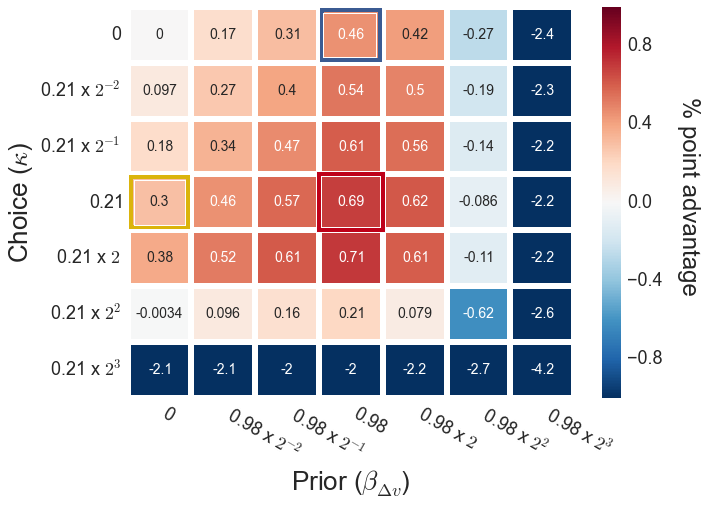

In [18]:
# Actual preference data heatmap
plt.figure(figsize=(10,7))

xlabels = ['0','0.98 x $2^{-2}$', '0.98 x $2^{-1}$', '0.98', '0.98 x $2$', '0.98 x $2^{2}$','0.98 x $2^{3}$']
ylabels = ['0','0.21 x $2^{-2}$', '0.21 x $2^{-1}$', '0.21', '0.21 x $2$', '0.21 x $2^{2}$','0.21 x $2^{3}$']

ax = sns.heatmap(actual_pref_sim_matrix, annot=True, vmax=1, vmin=-1, linewidth=5, xticklabels=xlabels, yticklabels=ylabels,
           annot_kws={'size':14})
ax.tick_params(labelsize=18)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
cax.set_title('% point advantage', loc='right', rotation=270, size=24, position=(5,0.71))

plt.xlabel('Prior ($\\beta_{\Delta v}$)', size=26)
plt.ylabel('Choice ($\\kappa$)', size=26)
plt.xticks(rotation=330, horizontalalignment='left')
plt.yticks(rotation=0)
#plt.suptitle('Advantage Over Neutral Actor (% point)', size=30)
#plt.title('Actual preference data', size=28, y=1.05)
#hm.tick_params(labelsize=14)

ax.add_patch(mpatches.Rectangle((3, 3),1,1,fill=False,edgecolor=sns.xkcd_rgb['scarlet'],linewidth=4))
ax.add_patch(mpatches.Rectangle((3.05, 6.05),0.9,0.9,fill=False,edgecolor=sns.xkcd_rgb['denim blue'],linewidth=4))
ax.add_patch(mpatches.Rectangle((0.05, 3.05),0.9,0.9,fill=False,edgecolor=sns.xkcd_rgb['gold'],linewidth=4))

ax.add_patch(mpatches.Rectangle((0.1, 3.1),0.8,0.8,fill=False,edgecolor=sns.xkcd_rgb['white'],linewidth=1)) # gold inner-border
ax.add_patch(mpatches.Rectangle((3.07, 6.1),0.83,0.8,fill=False,edgecolor=sns.xkcd_rgb['white'],linewidth=1)) # blue inner-border

plt.savefig('../figures/fig7a_left-sim_heatmap_actual.pdf', bbox_inches='tight')

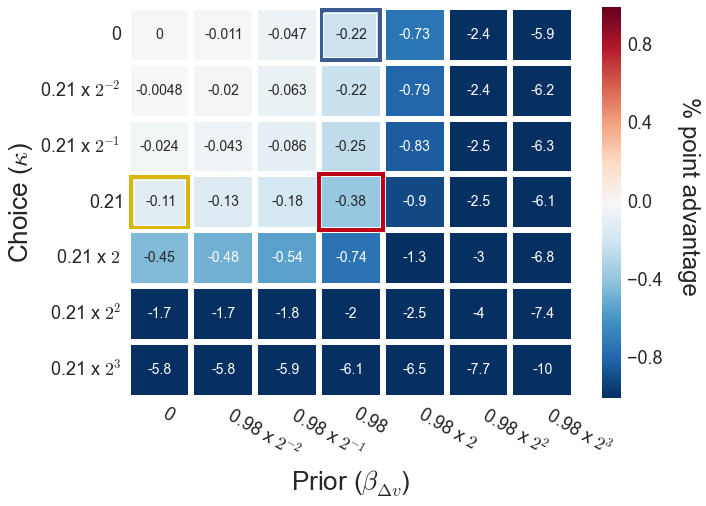

In [19]:
# Random preference data heatmap
plt.figure(figsize=(10,7))

xlabels = ['0','0.98 x $2^{-2}$', '0.98 x $2^{-1}$', '0.98', '0.98 x $2$', '0.98 x $2^{2}$','0.98 x $2^{3}$']
ylabels = ['0','0.21 x $2^{-2}$', '0.21 x $2^{-1}$', '0.21', '0.21 x $2$', '0.21 x $2^{2}$','0.21 x $2^{3}$']

ax = sns.heatmap(random_pref_sim_matrix, annot=True, vmax=1, vmin=-1, linewidth=5, xticklabels=xlabels, yticklabels=ylabels,
           annot_kws={'size':14})
ax.tick_params(labelsize=18)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
cax.set_title('% point advantage', loc='right', rotation=270, size=24, position=(5,0.71))

plt.xlabel('Prior ($\\beta_{\Delta v}$)', size=26)
plt.ylabel('Choice ($\\kappa$)', size=26)
plt.xticks(rotation=330, horizontalalignment='left')
plt.yticks(rotation=0)
#plt.suptitle('Advantage Over Neutral Actor (% point)', size=30)
#plt.title('Random preference data', size=28, y=1.05)
#hm.tick_params(labelsize=14)

ax.add_patch(mpatches.Rectangle((3, 3),1,1,fill=False,edgecolor=sns.xkcd_rgb['scarlet'],linewidth=4))
ax.add_patch(mpatches.Rectangle((3.05, 6.05),0.9,0.9,fill=False,edgecolor=sns.xkcd_rgb['denim blue'],linewidth=4))
ax.add_patch(mpatches.Rectangle((0.05, 3.05),0.9,0.9,fill=False,edgecolor=sns.xkcd_rgb['gold'],linewidth=4))

ax.add_patch(mpatches.Rectangle((0.1, 3.1),0.8,0.8,fill=False,edgecolor=sns.xkcd_rgb['white'],linewidth=1)) # gold inner-border
ax.add_patch(mpatches.Rectangle((3.07, 6.1),0.83,0.8,fill=False,edgecolor=sns.xkcd_rgb['white'],linewidth=1)) # blue inner-border
plt.savefig('../figures/fig7b_left-sim_heatmap_random.pdf', bbox_inches='tight')

In [21]:
def tradeoff_matrix(p_no_corr, vmin, vmax, xlabels, ylabels, annot=True, ax=None, max_box=True): 
    act = (1-p_no_corr)*actual_pref_sim_matrix
    ran = p_no_corr*random_pref_sim_matrix
    benefit_matrix = act + ran
    max_ix = np.where(benefit_matrix==benefit_matrix.max())
    sns.heatmap(benefit_matrix, xticklabels=xlabels, yticklabels=ylabels, linewidth=2, annot=annot, vmin=vmin, vmax=vmax, ax=ax, cbar=False)
    if max_box==True:
        ax.add_patch(mpatches.Rectangle((max_ix[1],6-max_ix[0]),1,1,fill=False,edgecolor=sns.xkcd_rgb['dark grey'],linewidth=4))
    #plt.xlabel('choice')

In [22]:
def tradeoff_matrix_values(p_no_corr, vmin, vmax, xlabels, ylabels): 
    act = (1-p_no_corr)*actual_pref_sim_matrix
    ran = p_no_corr*random_pref_sim_matrix
    benefit_matrix = act + ran
    return benefit_matrix

In [385]:
np.clip(np.random.randn(250, 250), -1, 1).shape

(250, 250)

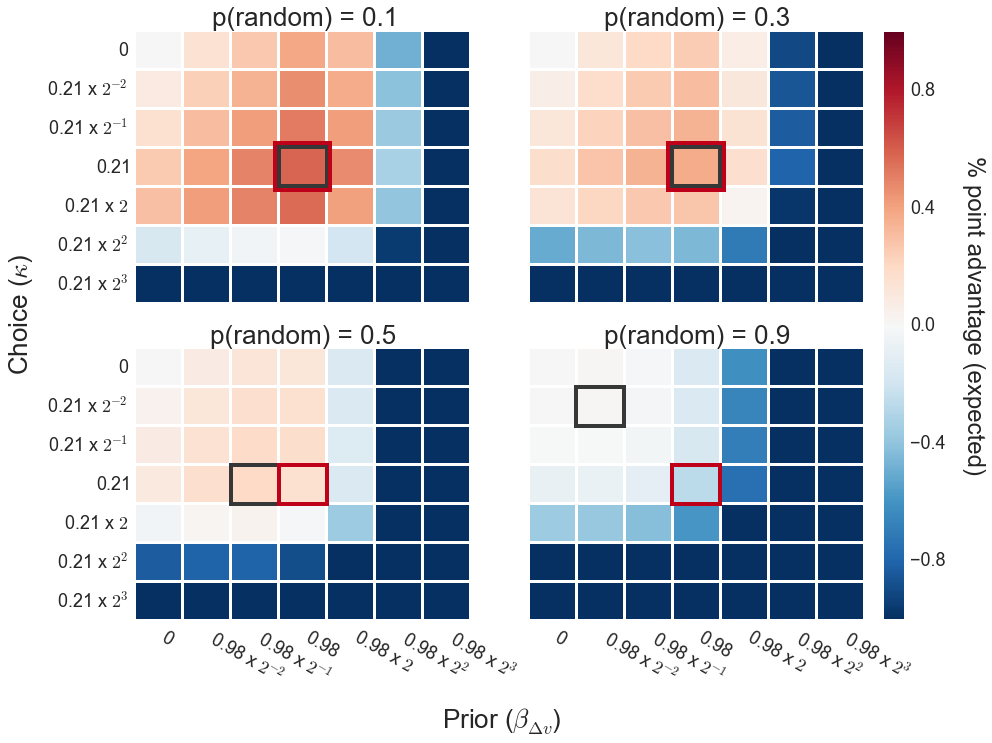

In [30]:
xlabels = ['0','0.98 x $2^{-2}$', '0.98 x $2^{-1}$', '0.98', '0.98 x $2$', '0.98 x $2^{2}$','0.98 x $2^{3}$']
ylabels = ['0','0.21 x $2^{-2}$', '0.21 x $2^{-1}$', '0.21', '0.21 x $2$', '0.21 x $2^{2}$','0.21 x $2^{3}$']
pl.rcParams['figure.figsize'] = (10.0, 7.0)
fig, ax = pl.subplots(2,2,squeeze=False, figsize=(14,10))

#plt.figure(figsize=(10,7))
fig.text(0.47, -0.03, 'Prior ($\\beta_{\Delta v}$)', size=26, ha='center')
fig.text(-0.02, 0.545, 'Choice ($\\kappa$)', size=26, va='center', rotation='vertical')

tradeoff_matrix(0.1, -1, 1, xlabels, ylabels, annot=False, ax=ax[0,0])
ax[0,0].set_title('p(random) = 0.1', size=26)
ax[0,0].add_patch(mpatches.Rectangle((2.92,2.9),1.16,1.2,fill=False,edgecolor=sns.xkcd_rgb['scarlet'],linewidth=4))
ax[0,0].get_xaxis().set_visible(False)
#ax[0,0].set_ylabel('Choice ($\\kappa$)', size=26)
ax[0,0].tick_params(labelsize=18)

tradeoff_matrix(0.3, -1, 1, xlabels, ylabels, annot=False, ax=ax[0,1])
ax[0,1].set_title('p(random) = 0.3', size=26)
ax[0,1].add_patch(mpatches.Rectangle((2.92,2.9),1.16,1.2,fill=False,edgecolor=sns.xkcd_rgb['scarlet'],linewidth=4))
ax[0,1].get_xaxis().set_visible(False)
ax[0,1].get_yaxis().set_visible(False)

tradeoff_matrix(0.5, -1, 1, xlabels, ylabels, annot=False, ax=ax[1,0])
ax[1,0].set_title('p(random) = 0.5', size=26)
ax[1,0].add_patch(mpatches.Rectangle((3,3),1,1,fill=False,edgecolor=sns.xkcd_rgb['scarlet'],linewidth=4))
#ax[1,0].set_xlabel('Prior ($\\beta_{\Delta v}$)', size=26)
#ax[1,0].set_ylabel('Choice ($\\kappa$)', size=26)
ax[1,0].tick_params(labelsize=18)
ax[1,0].set_xticklabels(xlabels, rotation=330, horizontalalignment='left')

tradeoff_matrix(0.9, -1, 1, xlabels, ylabels, annot=False, ax=ax[1,1])
ax[1,1].set_title('p(random) = 0.9', size=26)
ax[1,1].add_patch(mpatches.Rectangle((3,3),1,1,fill=False,edgecolor=sns.xkcd_rgb['scarlet'],linewidth=4))
ax[1,1].get_yaxis().set_visible(False)
#ax[1,1].set_xlabel('Prior ($\\beta_{\Delta v}$)', size=26)
ax[1,1].tick_params(labelsize=18)
ax[1,1].set_xticklabels(xlabels, rotation=330, horizontalalignment='left')

cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.816])
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap='RdBu_r', norm=mpl.colors.Normalize(vmin=-1, vmax=1), ticks=[-0.8,-0.4,0,0.4,0.8])
cb.outline.set_visible(False)

cbar_ax.tick_params(labelsize=18)
cbar_ax.set_title('% point advantage (expected)', loc='right', rotation=270, size=24, position=(5,0.75))

plt.tight_layout(pad=2)
fig.subplots_adjust(right=0.83)
plt.savefig('../figures/fig8-sim_heatmap_ev.pdf', bbox_inches='tight')

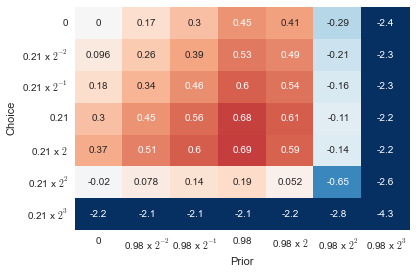

In [21]:
xlabels = ['0','0.98 x $2^{-2}$', '0.98 x $2^{-1}$', '0.98', '0.98 x $2$', '0.98 x $2^{2}$','0.98 x $2^{3}$']
ylabels = ['0','0.21 x $2^{-2}$', '0.21 x $2^{-1}$', '0.21', '0.21 x $2$', '0.21 x $2^{2}$','0.21 x $2^{3}$']
tradeoff_matrix(0.01, -1, 1, xlabels, ylabels, max_box=False)
plt.xlabel('Prior')
plt.ylabel('Choice')

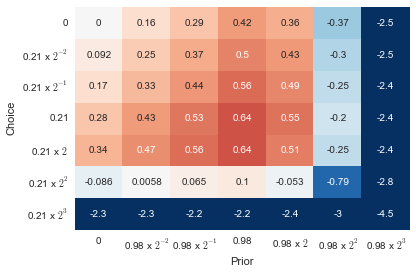

In [51]:
tradeoff_matrix(0.05, -1, 1, xlabels, ylabels, max_box=False)
plt.xlabel('Prior')
plt.ylabel('Choice')

In [56]:
tradeoff_matrix_values(0.05, -1, 1, xlabels, ylabels)[3,3]


0.63779320503313386

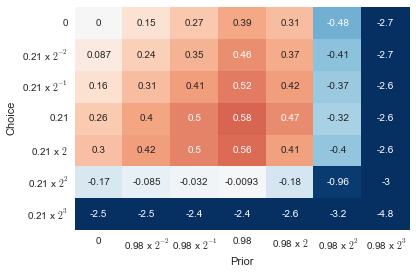

In [23]:
tradeoff_matrix(0.1, -1, 1, xlabels, ylabels, max_box=False)
plt.xlabel('Prior')
plt.ylabel('Choice')

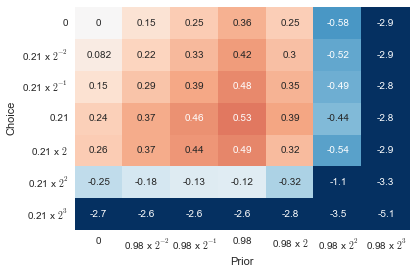

In [24]:
tradeoff_matrix(0.15, -1, 1, xlabels, ylabels, max_box=False)
plt.xlabel('Prior')
plt.ylabel('Choice')

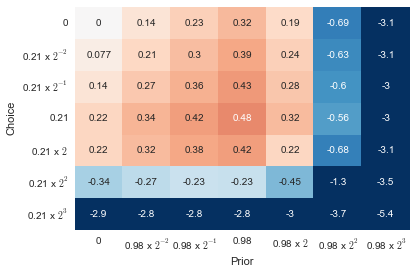

In [25]:
tradeoff_matrix(0.2, -1, 1, xlabels, ylabels, max_box=False)
plt.xlabel('Prior')
plt.ylabel('Choice')

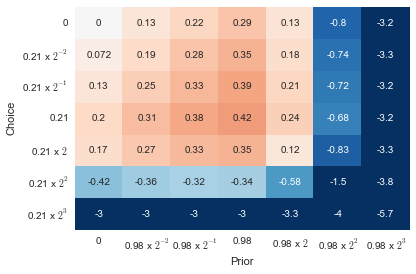

In [26]:
tradeoff_matrix(0.25, -1, 1, xlabels, ylabels, max_box=False)
plt.xlabel('Prior')
plt.ylabel('Choice')

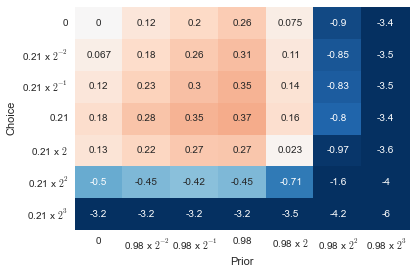

In [27]:
tradeoff_matrix(0.3, -1, 1, xlabels, ylabels, max_box=False)
plt.xlabel('Prior')
plt.ylabel('Choice')

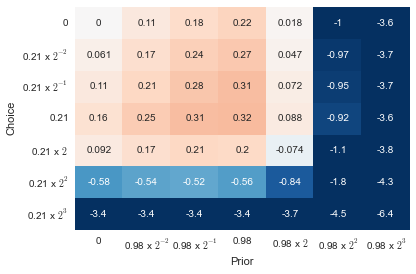

In [32]:
tradeoff_matrix(0.35, -1, 1, xlabels, ylabels, max_box=False)
plt.xlabel('Prior')
plt.ylabel('Choice')

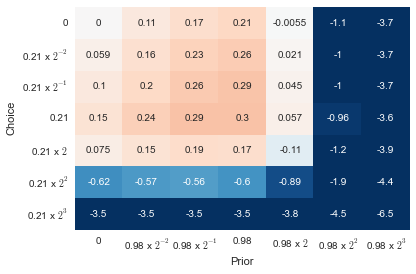

In [55]:
tradeoff_matrix(0.37, -1, 1, xlabels, ylabels, max_box=False)
plt.xlabel('Prior')
plt.ylabel('Choice')

In [57]:
tradeoff_matrix_values(0.37, -1, 1, xlabels, ylabels)[3,3]

0.29544942587701351

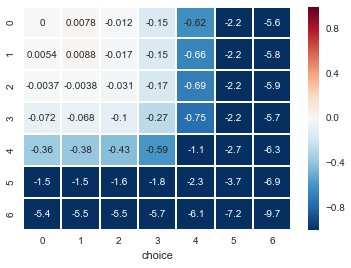

In [196]:
tradeoff_matrix(0.9, -1, 1)

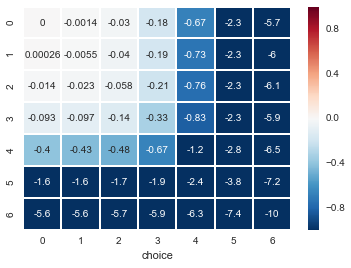

In [197]:
tradeoff_matrix(0.95, -1, 1)

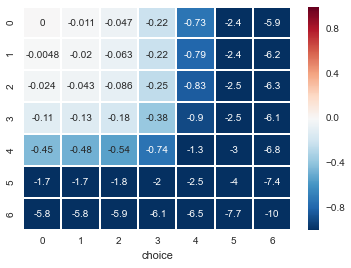

In [198]:
tradeoff_matrix(1, -1, 1)